/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


5479
1.05 18.48
0 th iteration :  tensor(0.4647, grad_fn=<MseLossBackward0>)
50 th iteration :  tensor(0.0622, grad_fn=<MseLossBackward0>)
100 th iteration :  tensor(0.0346, grad_fn=<MseLossBackward0>)
150 th iteration :  tensor(0.0191, grad_fn=<MseLossBackward0>)
200 th iteration :  tensor(0.0304, grad_fn=<MseLossBackward0>)
250 th iteration :  tensor(0.0413, grad_fn=<MseLossBackward0>)
300 th iteration :  tensor(0.0293, grad_fn=<MseLossBackward0>)
350 th iteration :  tensor(0.0164, grad_fn=<MseLossBackward0>)
400 th iteration :  tensor(0.0035, grad_fn=<MseLossBackward0>)
450 th iteration :  tensor(0.0006, grad_fn=<MseLossBackward0>)
500 th iteration :  tensor(0.0021, grad_fn=<MseLossBackward0>)
550 th iteration :  tensor(0.0021, grad_fn=<MseLossBackward0>)
600 th iteration :  tensor(0.0034, grad_fn=<MseLossBackward0>)
650 th iteration :  tensor(0.0095, grad_fn=<MseLossBackward0>)
700 th iteration :  tensor(0.0052, grad_fn=<MseLossBackward0>)
750 th iteration :  tensor(0.0019, grad_fn

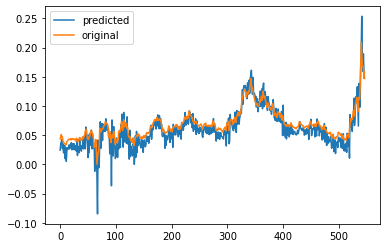

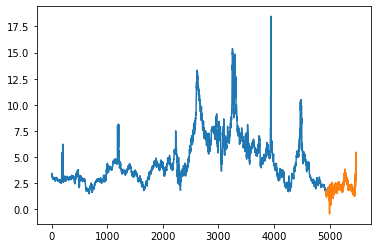

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch import nn

df = pd.read_csv("./data/naturalgas/daily.csv")

# Preprocess the data - Drop NA values in the dataset
df = df.dropna()
y = df['Price'].values
x = np.arange(1, len(y), 1)
print(len(y))

# Normalize the input range between 0 and 1
minm = y.min()
maxm = y.max()
print(minm, maxm)
y = (y - minm) / (maxm - minm)
X = []
Y = []
Sequence_Length = 10

# Iterate through the data to create input-output pairs
for i in range(0, len(y) - Sequence_Length - 1):  # Adjust loop bounds
    x_seq = []
    for j in range(i, i + Sequence_Length):
        x_seq.append(y[j])
    X.append(x_seq)
    Y.append(y[i + Sequence_Length])

# Convert lists to arrays
X = np.array(X)
Y = np.array(Y)

# Split the data as the train and test set
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42, shuffle=False, stratify=None)


class NGTimeSeries(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.len = x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.len


dataset = NGTimeSeries(x_train, y_train)
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset, shuffle=True, batch_size=256)


class RNNModel(nn.Module):
    def __init__(self):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=5, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        output, _status = self.rnn(x)
        output = output[:, -1, :]
        output = self.fc1(torch.relu(output))
        return output


model = RNNModel()

# optimizer , loss
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 1500

# training loop
for i in range(epochs):
    for j, data in enumerate(train_loader):
        y_pred = model(data[:][0].view(-1, Sequence_Length,
                                       1)).reshape(-1)
        loss = criterion(y_pred, data[:][1])
        loss.backward()
        optimizer.step()
    if i % 50 == 0:
        print(i, "th iteration : ", loss)

# test set actual vs predicted
test_set = NGTimeSeries(x_test, y_test)
test_pred = model(test_set[:][0].view(-1, 10, 1)).view(-1)
plt.plot(test_pred.detach().numpy(), label='predicted')
plt.plot(test_set[:][1].view(-1), label='original')
plt.legend()
plt.show()

# Undo normalization
y = y * (maxm - minm) + minm
y_pred = test_pred.detach().numpy() * (maxm - minm) + minm
plt.plot(y)
plt.plot(range(len(y) - len(y_pred), len(y)), y_pred)
plt.show()

In [2]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import random


# Define a class to load and preprocess the surname data
class SurnameDataset(Dataset):
    def __init__(self, data_folder, sequence_length=20):
        self.languages = {}
        self.languages_index = {}
        self.languages_list = []
        self.surname_data = []
        self.sequence_length = sequence_length

        # Load surname data from files
        for filename in glob.glob(data_folder + '/*.txt'):
            language = os.path.splitext(os.path.basename(filename))[0]
            self.languages_list.append(language)
            self.languages_index[language] = len(self.languages_index)
            with open(filename, 'r', encoding='utf-8') as file:
                surnames = [line.strip() for line in file]
                self.surname_data.extend([(surname, language) for surname in surnames])
                self.languages[language] = surnames

    def __len__(self):
        return len(self.surname_data)

    def __getitem__(self, idx):
        surname, language = self.surname_data[idx]
        # Convert surname characters to one-hot encoding
        surname_tensor = self.surname_to_tensor(surname)
        # Convert language to label index
        language_label = torch.tensor(self.languages_index[language], dtype=torch.long)
        return surname_tensor, language_label

    def surname_to_tensor(self, surname):
        tensor = torch.zeros(self.sequence_length, len(all_letters))
        for i, letter in enumerate(surname):
            tensor[i][all_letters.find(letter)] = 1
        return tensor


# Define the RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.2):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout

        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

        output, _ = self.rnn(x, (h0, c0))
        output = self.fc(output[:, -1, :])  # Take the last output only
        return output

    def init_hidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size)


# Define the training function
def train(model, dataloader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        running_loss = 0.0
        for surnames, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(surnames)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(dataloader)}')


# Define function to predict language from surname
def predict_language(model, surname):
    with torch.no_grad():
        input_tensor = dataset.surname_to_tensor(surname).unsqueeze(0)
        output = model(input_tensor)
        _, predicted_index = torch.max(output, 1)
        predicted_language = dataset.languages_list[predicted_index.item()]
        return predicted_language


# Define a function to randomly sample a surname from the dataset
def random_surname(dataset):
    surname, language = random.choice(dataset.dataset.surname_data)
    return surname


# Load and preprocess the data
data_folder = 'data/names'
all_letters = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
n_languages = 18
dataset = SurnameDataset(data_folder)

# Define hyperparameters
input_size = len(all_letters)
hidden_size = 128
output_size = n_languages
learning_rate = 0.001
batch_size = 64
num_epochs = 20

# Split dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoader objects for train and test sets
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=1, shuffle=True)

# Instantiate the model, loss function, and optimizer
model = RNN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train(model, train_loader, criterion, optimizer, num_epochs)

# Test the model
correct = 0
total = 0
with torch.no_grad():
    for surnames, labels in test_loader:
        outputs = model(surnames)
        _, predicted = torch.max(outputs.data, 1)
        total += 1
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: {100 * correct / total:.2f}%')

# Test predictions
for i in range(5):
    surname = random_surname(test_set)
    predicted_language = predict_language(model, surname)

Epoch 1/20, Loss: 1.8888809096765709
Epoch 2/20, Loss: 1.5539854769687729
Epoch 3/20, Loss: 1.4665243920102062
Epoch 4/20, Loss: 1.3706252693655006
Epoch 5/20, Loss: 1.2261553523075057
Epoch 6/20, Loss: 1.1342666134891282
Epoch 7/20, Loss: 1.0592579107835474
Epoch 8/20, Loss: 0.9964354453808758
Epoch 9/20, Loss: 0.9471829816164723
Epoch 10/20, Loss: 0.9042578059363651
Epoch 11/20, Loss: 0.8581614582187151
Epoch 12/20, Loss: 0.8160916280698967
Epoch 13/20, Loss: 0.7818332859481948
Epoch 14/20, Loss: 0.7510241686822884
Epoch 15/20, Loss: 0.7023994828837802
Epoch 16/20, Loss: 0.6743598022308958
Epoch 17/20, Loss: 0.6465715102228036
Epoch 18/20, Loss: 0.6205530227180496
Epoch 19/20, Loss: 0.5985798904620319
Epoch 20/20, Loss: 0.5805138956265621
Accuracy on test set: 79.15%


In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader


class MyTextDataset(Dataset):
    def __init__(self):
        f = open("./data/sherlock.txt", "r")
        text = f.read().lower().strip()
        self.seq_length = 7
        self.X, self.y = self.tokens2sequence(text, sequence_length=self.seq_length)
        self.vocab = sorted(set(text))
        self.chr_to_idx = {chr: i for i, chr in enumerate(self.vocab)}
        self.idx_to_chr = {i: chr for chr, i in self.chr_to_idx.items()}

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        X_idx = [self.chr_to_idx[char] for char in self.X[idx]]
        y_idx = self.chr_to_idx[self.y[idx]]
        return torch.tensor(X_idx), torch.tensor(y_idx)

    def tokens2sequence(self, tokens, sequence_length):
        X, y = [], []
        for i in range(len(tokens) - sequence_length):
            X.append(tokens[i:i + sequence_length])
            y.append(tokens[i + sequence_length])
        return X, y


class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_size=32, hidden_size=64):
        super(RNNModel, self).__init__()
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size

        self.embed = nn.Embedding(self.vocab_size, self.embedding_size)
        self.rnn = nn.RNN(input_size=self.embedding_size, hidden_size=self.hidden_size, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, self.vocab_size)

    def forward(self, x):
        embed = self.embed(x)
        output, _ = self.rnn(embed)
        output = self.fc(output[:, -1, :])
        return output


def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)


def generate_text(model, initial_text, length, device):
    model.eval()
    with torch.no_grad():
        generated_text = initial_text.lower()
        for _ in range(length):
            input_tensor = torch.tensor([[dataset.chr_to_idx[char] for char in generated_text[-7:]]]).to(device)
            output = model(input_tensor)
            _, predicted_idx = output.max(1)
            predicted_char = dataset.idx_to_chr[predicted_idx.item()]
            generated_text += predicted_char
    return generated_text


# Initialize dataset and dataloader
dataset = MyTextDataset()
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Initialize the model, loss function, and optimizer
model = RNNModel(vocab_size=len(dataset.vocab))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, dataloader, optimizer, criterion, device)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}")

# Generate text using the trained model
initial_text = "Sherlock "
generated_text = generate_text(model, initial_text, length=10, device=device)
print("\nGenerated text:")
print(generated_text)

Epoch 1/10, Loss: 1.9568
Epoch 2/10, Loss: 1.7477
Epoch 3/10, Loss: 1.6970
Epoch 4/10, Loss: 1.6688
Epoch 5/10, Loss: 1.6513
Epoch 6/10, Loss: 1.6380
Epoch 7/10, Loss: 1.6284
Epoch 8/10, Loss: 1.6202
Epoch 9/10, Loss: 1.6135
Epoch 10/10, Loss: 1.6081

Generated text:
sherlock that i sho
